# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [2]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [3]:
data['verse'][18]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah'

In [4]:
!pip install unidecode
from unidecode import unidecode
def remove_non_standard(text):
    return unidecode(text)

You should consider upgrading via the '/usr/local/opt/pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


In [5]:
data['verse'] = data['verse'].apply(lambda x: remove_non_standard(x))

In [6]:
data['verse'][18]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah'

❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [7]:
data.shape

(3975, 2)

In [8]:
data = data.drop_duplicates(subset='verse')

In [9]:
data.shape

(3029, 2)

In [10]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [11]:
data.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     777
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [12]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [13]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [14]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [15]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [16]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.26% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [17]:
# YOUR CODE HERE
from tensorflow.keras.preprocessing.text import text_to_word_sequence
data['seq'] = data.apply(lambda x: text_to_word_sequence(x['verse']), axis=1)

<ipython-input-17-96f482847803>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['seq'] = data.apply(lambda x: text_to_word_sequence(x['verse']), axis=1)


In [18]:
data.head()

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

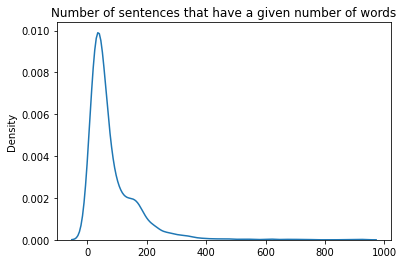

In [19]:
# YOUR CODE HERE
def plot_hist(X):
    len_ = [len(_) for _ in X]
    sns.kdeplot(len_).set_title('Number of sentences that have a given number of words')
    
plot_hist(data['seq'])

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [20]:
# YOUR CODE HERE
data = data[data['seq'].map(len) < 300]

In [21]:
data.shape

(2948, 3)

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [22]:
from gensim.models import Word2Vec

/usr/local/opt/pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [23]:
word2vec = Word2Vec(sentences=data['seq'], vector_size=100, epochs=50)

In [24]:
# check vector length
len(word2vec.wv['i'])

100

In [25]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [26]:
data['embed'] = data['seq'].apply(lambda x: embedding(word2vec, x))

In [27]:
# Check 
assert len(data['embed']) == len(data)

In [28]:
data.head()

,artist,verse,seq,embed
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]","[[[-1.429893, 0.5023378, -0.6813524, -0.662161..."
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[[-1.0238428, 0.1312744, -0.2245312, -0.68246..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you...","[[[-1.0238428, 0.1312744, -0.2245312, -0.68246..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a...","[[[0.24405384, 0.9424773, 0.92803735, -1.59805..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[[-1.0238428, 0.1312744, -0.2245312, -0.68246..."


### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
X_embed = embedding(word2vec, data['seq'])
X = pad_sequences(X_embed, dtype='float32', padding='post', maxlen=300)

In [31]:
X.shape

(2948, 300, 100)

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [32]:
# YOUR CODE HERE
from sklearn.preprocessing import OneHotEncoder

In [33]:
ohe = OneHotEncoder(sparse = False) # Instanciate encoder
ohe.fit(data[['artist']]) # Fit encoder
y = ohe.transform(data[['artist']])

In [34]:
y.shape

(2948, 3)

👉 We train/test split the dataset below for you

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [61]:
X.shape

(2948, 300, 100)

In [37]:
y.shape

(2948, 3)

In [38]:
unique, counts = np.unique(y[:,0], return_counts=True)
dict(zip(unique, counts))

{0.0: 1612, 1.0: 1336}

In [39]:
unique, counts = np.unique(y[:,1], return_counts=True)
dict(zip(unique, counts))

{0.0: 2098, 1.0: 850}

In [40]:
unique, counts = np.unique(y[:,2], return_counts=True)
dict(zip(unique, counts))

{0.0: 2186, 1.0: 762}

In [41]:
score_baseline = 1336 / 2948

In [42]:
score_baseline

0.4531886024423338

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [43]:
# YOUR CODE HERE
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [72]:
model = Sequential()
model.add(layers.Masking())
model.add(layers.LSTM(20, activation="tanh"))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(3, activation="softmax"))


❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [73]:
from tensorflow.keras.callbacks import EarlyStopping

In [74]:
X_train.shape

(2358, 300, 100)

In [75]:
y_train.shape

(2358, 3)

In [84]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
es = EarlyStopping(patience=4)

history = model.fit(X_train, y_train,
          validation_split=0.3,
          batch_size=16, epochs=20, verbose=0, callbacks=[es]);

❓ **Plot the training and validation losses through training**

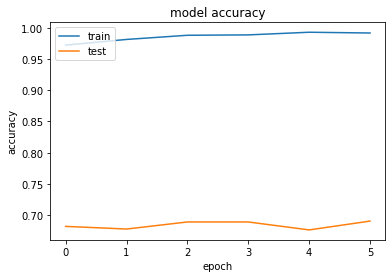

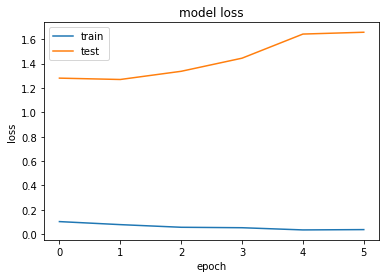

<Figure size 432x288 with 0 Axes>

In [85]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Save your accuracy on test set as `score_test`**

In [88]:
# YOUR CODE HERE
res = model.evaluate(X_test, y_test)
score_test = res[1]
score_test

19/19 [==============================] - 1s 33ms/step - loss: 1.7964 - accuracy: 0.6441


0.6440678238868713

🧪 **Send your results below**

In [89]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()